In [15]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [16]:
def generate(list_of_params, m, C=512, L=96):
    x = []
    y = []

    for (A, T, S) in list_of_params:
        for _ in range(m):
            # Random phase shift in [0, T)
            phase_shift = np.random.uniform(0, T)
            # Generate total data points
            total_months = C + L
            months_passed = np.arange(total_months) + phase_shift
            # Calculate sine values
            sine_values = A * np.sin(2 * np.pi / T * months_passed)
            # Calculate linear trend
            linear_values = S * months_passed
            # Combine sine and linear trend
            values = sine_values + linear_values
            # Split into input and output
            x.append(values[:C])
            y.append(values[C:C+L])

    x = np.array(x)
    y = np.array(y)
    return x, y

def convert_to_df(x, is_input=True, start_date='1945-01-01', L=96):
    if is_input:
        base_date = pd.Timestamp(start_date)
    else:
        # Offset by L months for outputs
        base_date = pd.Timestamp(start_date) + DateOffset(months=L)

    n = len(x)
    dates = [base_date + DateOffset(months=i) for i in range(n)]
    if is_input:
        df = pd.DataFrame({
            'ds': dates,
            'y': x
        })
    else:
        df = pd.DataFrame({
            'ds': dates,
            'y': x
        })
    return df

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random


m = 20
C = 512
L = 96
num_params = 100
list_of_params = []

for _ in range(num_params):
    A = 1
    S = 0
    T = random.randint(64, 512)
    list_of_params.append((A, T, S))
print("Generated Parameters (A, T, S):")

for idx, param in enumerate(list_of_params):
    print(f"Param {idx+1}: A={param[0]}, T={param[1]}, S={param[2]}")
        
x, y = generate(list_of_params=list_of_params, m=m, C=C, L=L)



Generated Parameters (A, T, S):
Param 1: A=1, T=77, S=0
Param 2: A=1, T=269, S=0
Param 3: A=1, T=229, S=0
Param 4: A=1, T=367, S=0
Param 5: A=1, T=460, S=0
Param 6: A=1, T=503, S=0
Param 7: A=1, T=444, S=0
Param 8: A=1, T=380, S=0
Param 9: A=1, T=247, S=0
Param 10: A=1, T=461, S=0
Param 11: A=1, T=138, S=0
Param 12: A=1, T=449, S=0
Param 13: A=1, T=142, S=0
Param 14: A=1, T=247, S=0
Param 15: A=1, T=421, S=0
Param 16: A=1, T=321, S=0
Param 17: A=1, T=259, S=0
Param 18: A=1, T=97, S=0
Param 19: A=1, T=343, S=0
Param 20: A=1, T=259, S=0
Param 21: A=1, T=478, S=0
Param 22: A=1, T=280, S=0
Param 23: A=1, T=111, S=0
Param 24: A=1, T=436, S=0
Param 25: A=1, T=433, S=0
Param 26: A=1, T=370, S=0
Param 27: A=1, T=122, S=0
Param 28: A=1, T=286, S=0
Param 29: A=1, T=174, S=0
Param 30: A=1, T=213, S=0
Param 31: A=1, T=281, S=0
Param 32: A=1, T=223, S=0
Param 33: A=1, T=142, S=0
Param 34: A=1, T=460, S=0
Param 35: A=1, T=348, S=0
Param 36: A=1, T=350, S=0
Param 37: A=1, T=147, S=0
Param 38: A=1, T=

In [18]:
# Convert the first generated time series (for example) into a DataFrame
# This converts input series (x[0]) to a DataFrame starting from 1945-01-01
df_input = convert_to_df(x[0], is_input=True, start_date='1945-01-01')

# This converts output series (y[0]) to a DataFrame starting 96 months later
df_output = convert_to_df(y[0], is_input=False, start_date='1945-01-01', L=L)

# Display the DataFrame for inputs
print("Input DataFrame:")
print(df_input.head())

# Display the DataFrame for outputs
print("\nOutput DataFrame:")
print(df_output.head())

Input DataFrame:
          ds         y
0 1945-01-01  0.141478
1 1945-02-01  0.060318
2 1945-03-01 -0.021244
3 1945-04-01 -0.102664
4 1945-05-01 -0.183401

Output DataFrame:
          ds         y
0 1953-01-01  0.714874
1 1953-02-01  0.769491
2 1953-03-01  0.818987
3 1953-04-01  0.863033
4 1953-05-01  0.901335


In [19]:
df_input

,ds,y
0,1945-01-01,0.141478
1,1945-02-01,0.060318
2,1945-03-01,-0.021244
3,1945-04-01,-0.102664
4,1945-05-01,-0.183401
...,...,...
507,1987-04-01,0.378749
508,1987-05-01,0.452926
509,1987-06-01,0.524088
510,1987-07-01,0.591763


In [20]:
df_output

,ds,y
0,1953-01-01,0.714874
1,1953-02-01,0.769491
2,1953-03-01,0.818987
3,1953-04-01,0.863033
4,1953-05-01,0.901335
...,...,...
91,1960-08-01,0.933033
92,1960-09-01,0.900602
93,1960-10-01,0.862177
94,1960-11-01,0.818015


In [21]:
# Load and process the ETTm1 dataset
import pandas as pd
import numpy as np

# Load the dataset
file_path = "/kaggle/input/electricity/ETTm1.csv"
data = pd.read_csv(file_path)

# Convert 'date' column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Select the columns to predict
columns_to_predict = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']

# Define context and prediction window sizes
C = 512  # Context window (input size)
L = 96   # Prediction window (output size)

# Prepare input (x) and output (y) sequences for all selected columns
x = {col: [] for col in columns_to_predict}
y = {col: [] for col in columns_to_predict}

for col in columns_to_predict:
    time_series = data[col]
    for i in range(len(time_series) - C - L):
        x[col].append(time_series[i:i+C].values)
        y[col].append(time_series[i+C:i+C+L].values)

# Convert to numpy arrays
x = {col: np.array(x[col]) for col in columns_to_predict}
y = {col: np.array(y[col]) for col in columns_to_predict}

# Display the shapes of the prepared datasets for each column
for col in columns_to_predict:
    print(f"{col} - Input shape: {x[col].shape}, Output shape: {y[col].shape}")


HUFL - Input shape: (69072, 512), Output shape: (69072, 96)
HULL - Input shape: (69072, 512), Output shape: (69072, 96)
MUFL - Input shape: (69072, 512), Output shape: (69072, 96)
MULL - Input shape: (69072, 512), Output shape: (69072, 96)
LUFL - Input shape: (69072, 512), Output shape: (69072, 96)
LULL - Input shape: (69072, 512), Output shape: (69072, 96)


08:35:14 - cmdstanpy - INFO - Chain [1] start processing
08:35:14 - cmdstanpy - INFO - Chain [1] done processing



Evaluating zero-shot approach for column: HUFL
MSE for HUFL: 4.9378


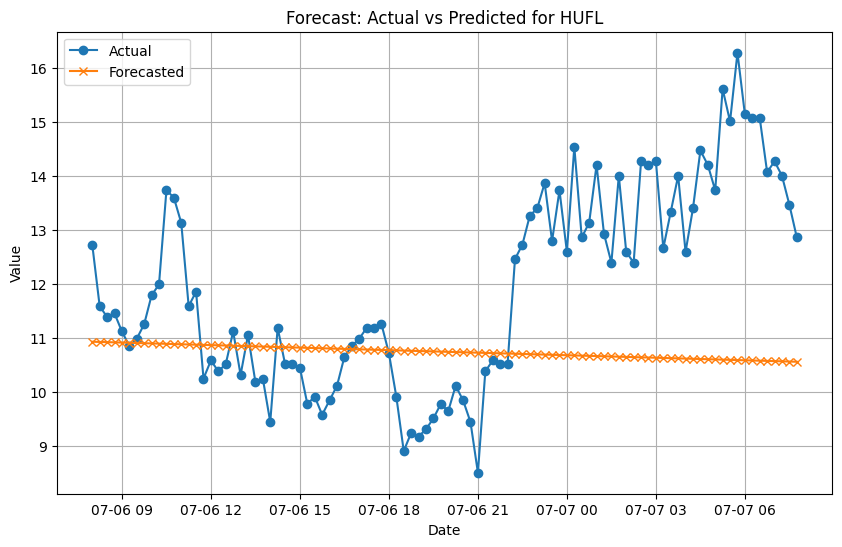

08:35:14 - cmdstanpy - INFO - Chain [1] start processing
08:35:14 - cmdstanpy - INFO - Chain [1] done processing



Evaluating zero-shot approach for column: HULL
MSE for HULL: 0.8674


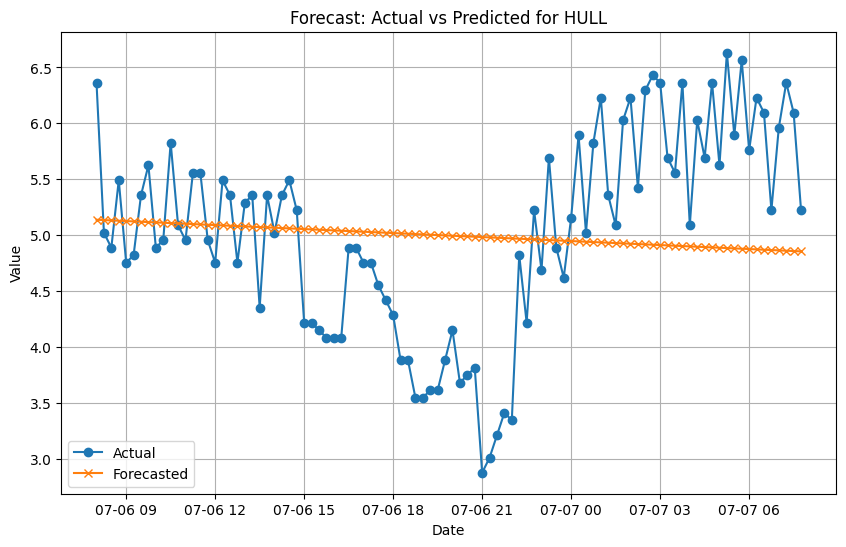

08:35:15 - cmdstanpy - INFO - Chain [1] start processing
08:35:15 - cmdstanpy - INFO - Chain [1] done processing



Evaluating zero-shot approach for column: MUFL
MSE for MUFL: 5.3562


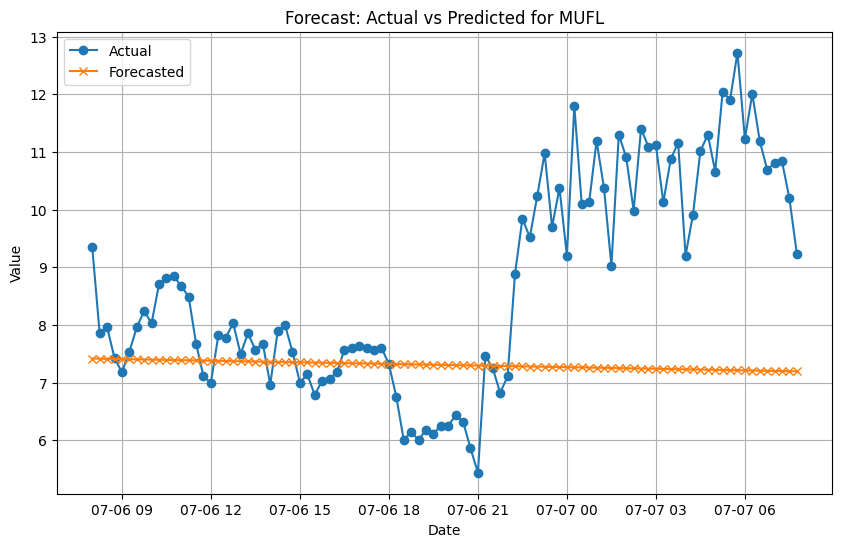

08:35:15 - cmdstanpy - INFO - Chain [1] start processing
08:35:16 - cmdstanpy - INFO - Chain [1] done processing



Evaluating zero-shot approach for column: MULL
MSE for MULL: 0.5450


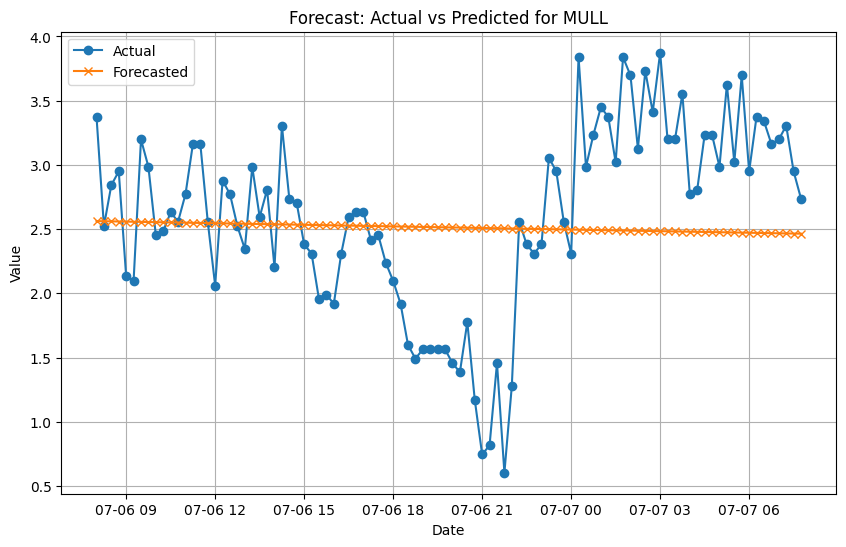

08:35:16 - cmdstanpy - INFO - Chain [1] start processing
08:35:16 - cmdstanpy - INFO - Chain [1] done processing



Evaluating zero-shot approach for column: LUFL
MSE for LUFL: 0.2022


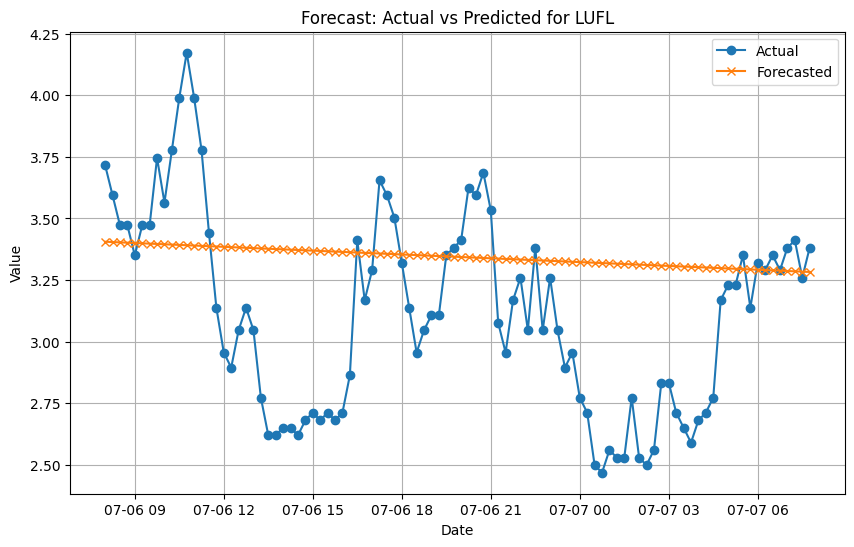

08:35:16 - cmdstanpy - INFO - Chain [1] start processing
08:35:17 - cmdstanpy - INFO - Chain [1] done processing



Evaluating zero-shot approach for column: LULL
MSE for LULL: 0.0760


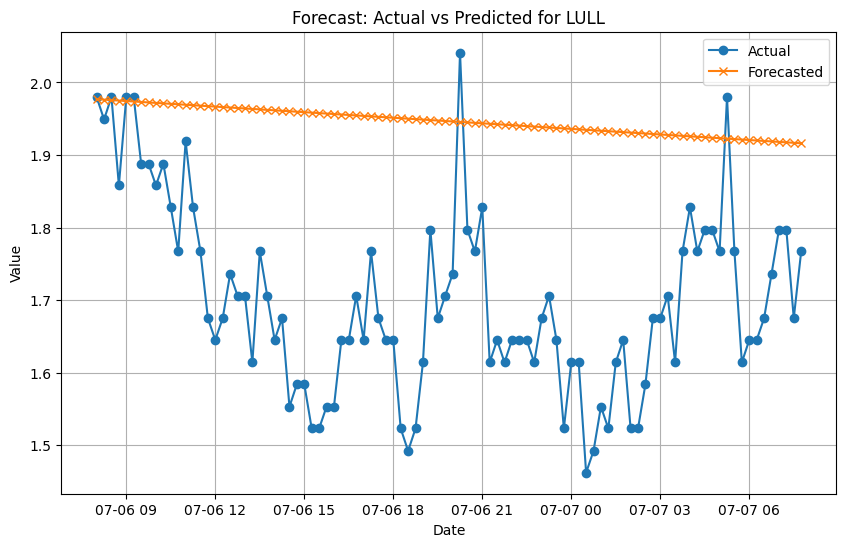

In [23]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = '/kaggle/input/electricity/ETTm1.csv'  # Adjust the file path as needed
data = pd.read_csv(file_path)

# Generate a synthetic 'date' column starting from 2016-07-01 and incrementing every 15 minutes
start_date = pd.Timestamp('2016-07-01 00:00:00')
data['date'] = pd.date_range(start=start_date, periods=len(data), freq='15min')

# Define columns to predict
columns_to_predict = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']

# Define the context and prediction window
C = 512  # Context window (input size)
L = 96   # Prediction window (output size)

# Initialize a dictionary to store results for each column
all_results = {}

# Loop through each column and treat it as a separate time series
for column in columns_to_predict:
    print(f"\nEvaluating zero-shot approach for column: {column}")
    
    # Prepare the data for Prophet using the first 512 values
    df = data[['date', column]].rename(columns={'date': 'ds', column: 'y'}).dropna()
    df_train = df.iloc[:C]  # First 512 values
    df_test = df.iloc[C:C+L]  # Next 96 values as ground truth
    
    # Initialize the Prophet model
    model = Prophet(
        yearly_seasonality=False,  # Disable yearly seasonality
        weekly_seasonality=False,  # Disable weekly seasonality
        daily_seasonality=False,   # Disable daily seasonality
        changepoint_prior_scale=0.5  # Increase flexibility for trend changes
    )
    
    # Fit the model only on the first 512 values
    model.fit(df_train)
    
    # Generate a future dataframe for exactly L predictions
    future = pd.DataFrame({
        'ds': pd.date_range(df_train['ds'].iloc[-1] + pd.Timedelta(minutes=15), periods=L, freq='15min')
    })
    
    # Predict future values
    forecast = model.predict(future)
    
    # Restrict forecast to the next 96 predictions
    forecast = forecast.iloc[:L]
    
    # Evaluate the forecast: merge actual vs predicted for the test set
    result = pd.merge(df_test, forecast[['ds', 'yhat']], on='ds')
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(result['y'], result['yhat'])
    print(f"MSE for {column}: {mse:.4f}")
    
    # Plot actual vs forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(result['ds'], result['y'], label='Actual', marker='o')
    plt.plot(result['ds'], result['yhat'], label='Forecasted', marker='x')
    plt.title(f"Forecast: Actual vs Predicted for {column}")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
